In [5]:
import pandas as pd
import numpy as np

res_df = pd.read_csv('../datasets/ams_order_results.csv.gz')
train_df = pd.read_csv('../datasets/folds/training_df_single_fold_with_clustering.csv.gz')

---
## Total Hits of Ordered Compounds

In [6]:
print('Total hits: {0:.0f} out of {1:.0f}. Hit Rate: {2:.2f} %'.format(res_df['Hit'].sum(), res_df.shape[0], 
                                                           100.0*(res_df['Hit'].sum()/res_df.shape[0])))

Total hits: 412 out of 1024. Hit Rate: 40.23 %


---
## Hits by Selection/Model Type

In [19]:
RF_all = res_df[res_df['Selection'].isin(['Prediction', 'Both'])]
BL_all = res_df[res_df['Selection'].isin(['Baseline', 'Both'])]
RF_but_not_BL = res_df[res_df['Selection'].isin(['Prediction'])]
BL_but_not_RF = res_df[res_df['Selection'].isin(['Baseline'])]
overlap_selection =  res_df[res_df['Selection'] == 'Both']

summary_by_selection = []
for df in [res_df, RF_all, BL_all, overlap_selection, RF_but_not_BL, BL_but_not_RF]:
    summary_by_selection.append([df.shape[0], df['Hit'].sum()])
    
index_names = ['RF or BL All', 'RF All', 'BL All', 
               'RF AND BL overlap', 'RF but not BL', 'BL but not RF']
summary_df = pd.DataFrame(data=summary_by_selection,
                          columns=['Count', 'Hits'],
                          index=index_names)

summary_df['Misses'] = summary_df['Count'] - summary_df['Hits']
summary_df['Hit Rate'] = 100.0*(summary_df['Hits'] / summary_df['Count'])
summary_df

,Count,Hits,Misses,Hit Rate
RF or BL All,1024,412,612,40.234375
RF All,701,337,364,48.074180
BL All,705,256,449,36.312057
RF AND BL overlap,382,181,201,47.382199
RF but not BL,319,156,163,48.902821
BL but not RF,323,75,248,23.219814


- We can see that the RF model when given similar budget to the Baseline achieves a ~10% increase in hit rate (37.4% vs 48.4%). 
- RF and the baseline agree in selecting 382 cpds. Thus they agree on 183 of their hits. 
- RF selects 319 cpds not selected by the baseline. It finds 156 hits among these. 
- Baseline selects 323 cpds not selected by the RF. It finds 81 hits among these. 
- From the above, the RF manages to find 75 more hits than the baseline. 
- Need to see diversity/novelty of RF vs BL hits. 

---
## Look at scaffold/novel hits

Unique Scaffold Hits counts the number of unique scaffolds with hits in the prospective dataset.

Generalization Scaffold Hits counts the number of unique scaffolds with hits that were NOT present in the training set. In other words, scaffolds that the model was not trained on. 

In [40]:
train_hits = train_df[train_df['PriA-SSB AS Activity'] == 1]

cluster_cols = ['BT_0.2 ID', 'BT_0.3 ID', 'BT_0.4 ID']
scaffold_summary = []
for df in [res_df, RF_all, BL_all, RF_but_not_BL, BL_but_not_RF, overlap_selection]:
    ref_hits = df[df['Hit'] == 1]
    tmp_list = []
    for cluster_col in cluster_cols:
        scaffold_hit_count = ref_hits[cluster_col].unique().shape[0]
        generalization_scaffold_count = np.setdiff1d(ref_hits[cluster_col].unique(), train_hits[cluster_col].unique()).shape[0]
        tmp_list.extend([scaffold_hit_count, generalization_scaffold_count])
    scaffold_summary.append(tmp_list)
scaffol_df = pd.DataFrame(data=novel_summary,
                          columns=['Unique Scaffold Hits (BT 0.2)', 'Generalization Scaffold Hits (BT 0.2)',
                                      'Unique Scaffold Hits (BT 0.3)', 'Generalization Scaffold Hits (BT 0.3)',
                                      'Unique Scaffold Hits (BT 0.4)', 'Generalization Scaffold Hits (BT 0.4)'],
                          index=index_names)
scaffol_df

,Unique Scaffold Hits (BT 0.2),Generalization Scaffold Hits (BT 0.2),Unique Scaffold Hits (BT 0.3),Generalization Scaffold Hits (BT 0.3),Unique Scaffold Hits (BT 0.4),Generalization Scaffold Hits (BT 0.4)
RF or BL All,351,304,242,138,169,72
RF All,295,258,217,132,142,61
BL All,200,153,124,21,115,30
RF AND BL overlap,151,151,130,120,72,44
RF but not BL,63,48,43,7,40,13
BL but not RF,144,107,99,15,88,19


---
## Look at rf_rank for cpds selected by Baseline but not by RF
How close were some of the hits selected by the baseline to the RF model.

In [6]:
rank_rf_bl = BL_but_not_RF.sort_values('rf_rank')[['rf_rank', 'Hit']]
rank_rf_bl

,rf_rank,Hit
146,1778.0,0
198,1779.0,0
184,1793.0,0
1005,1801.0,1
472,1823.0,0
306,1826.0,1
830,1846.0,1
783,1874.0,1
677,1898.0,1
944,1899.0,0


In [7]:
print('Top-2500 RF hit increase estimate: {} hits'.format(rank_rf_bl[rank_rf_bl['rf_rank'] < 2500]['Hit'].sum()))
print('Top-5000 RF hit increase estimate: {} hits'.format(rank_rf_bl[rank_rf_bl['rf_rank'] < 5000]['Hit'].sum()))
print('Top-10000 RF hit increase estimate: {} hits'.format(rank_rf_bl[rank_rf_bl['rf_rank'] < 10000]['Hit'].sum()))

Top-2500 RF hit increase estimate: 19 hits
Top-5000 RF hit increase estimate: 40 hits
Top-10000 RF hit increase estimate: 55 hits


By looking at cpds selected by baseline but not by RF, we can look at how many of those hits the RF model would have found if given more budget. 

---
## Plot of Budget vs Total Hits

By using cpd prediction rank, we can plot budget vs total hits.

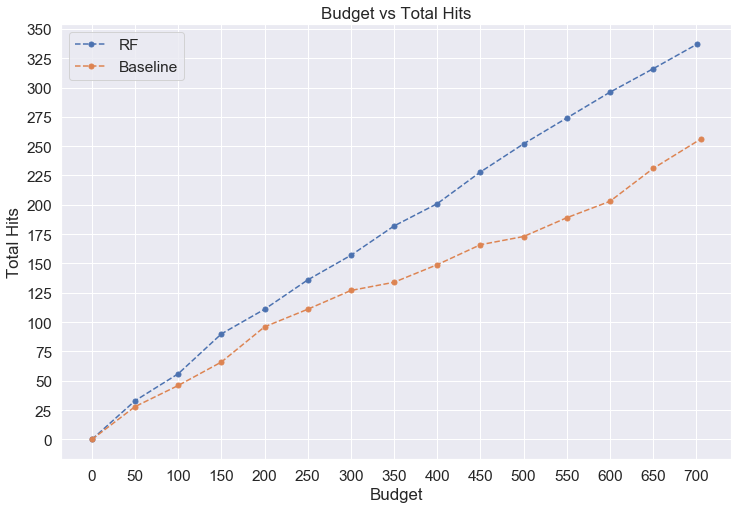

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1.4)

RF_all_ranked = res_df[res_df['Selection'].isin(['Prediction', 'Both'])].sort_values('rf_rank')
budget_arr = np.arange(0, RF_all_ranked.shape[0], 50)
budget_arr[-1] = RF_all_ranked.shape[0]
total_hits_arr = np.zeros_like(budget_arr)
for i, b in enumerate(budget_arr):
    total_hits_arr[i] = RF_all_ranked.iloc[:b,:]['Hit'].sum()

plt.figure(figsize=(12,8))
plt.plot(budget_arr, total_hits_arr, linestyle='--', marker='o', markersize=5)

BL_all_ranked = res_df[res_df['Selection'].isin(['Baseline', 'Both'])].sort_values('baseline_rank')
budget_arr = np.arange(0, BL_all_ranked.shape[0], 50)
budget_arr[-1] = BL_all_ranked.shape[0]
total_hits_arr = np.zeros_like(budget_arr)
for i, b in enumerate(budget_arr):
    total_hits_arr[i] = BL_all_ranked.iloc[:b,:]['Hit'].sum()

plt.plot(budget_arr, total_hits_arr, linestyle='--', marker='o', markersize=5)
plt.xticks(np.arange(0, 750, 50))
plt.yticks(np.arange(0, 351, 25))
plt.xlabel('Budget')
plt.ylabel('Total Hits')
plt.legend(['RF', 'Baseline'])
plt.title('Budget vs Total Hits')
plt.show()

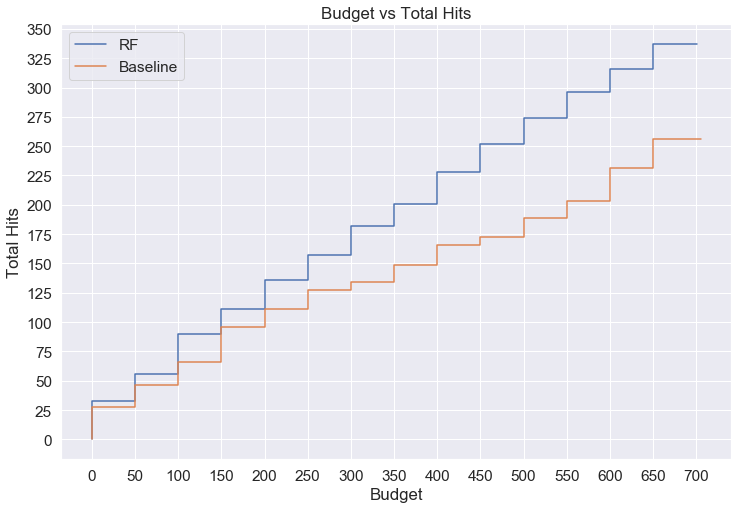

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1.4)

RF_all_ranked = res_df[res_df['Selection'].isin(['Prediction', 'Both'])].sort_values('rf_rank')
budget_arr = np.arange(0, RF_all_ranked.shape[0], 50)
budget_arr[-1] = RF_all_ranked.shape[0]
total_hits_arr = np.zeros_like(budget_arr)
for i, b in enumerate(budget_arr):
    total_hits_arr[i] = RF_all_ranked.iloc[:b,:]['Hit'].sum()

plt.figure(figsize=(12,8))
sns.lineplot(x=budget_arr, y=total_hits_arr, drawstyle='steps-pre')

BL_all_ranked = res_df[res_df['Selection'].isin(['Baseline', 'Both'])].sort_values('baseline_rank')
budget_arr = np.arange(0, BL_all_ranked.shape[0], 50)
budget_arr[-1] = BL_all_ranked.shape[0]
total_hits_arr = np.zeros_like(budget_arr)
for i, b in enumerate(budget_arr):
    total_hits_arr[i] = BL_all_ranked.iloc[:b,:]['Hit'].sum()

sns.lineplot(x=budget_arr, y=total_hits_arr, drawstyle='steps-pre')
plt.xticks(np.arange(0, 750, 50))
plt.yticks(np.arange(0, 351, 25))
plt.xlabel('Budget')
plt.ylabel('Total Hits')
plt.legend(['RF', 'Baseline'])
plt.title('Budget vs Total Hits')
plt.show()